In [6]:
from pathlib import Path
import requests
import unicodedata
import json
from collections import Counter, defaultdict
import base64

from IPython.display import Image, display
import torch
import numpy as np
from jaxtyping import Int, Float
import matplotlib.pyplot as plt

def mm(graph: str):
  """for plotting mermaid.js diagrams"""
  graphbytes = graph.encode("utf-8")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

A *Recurrent Neural Network* is a function 
$$ 
	r : \R^p \times \R^m \to \R^o 
$$ 
where $p$ is the input dimension, $m$ is the hidden state dimension and $o$ is the output dimension. The hidden state $h_t$ depends on the previous hidden state $h_{t-1}$ and the current input $x_t$: 
 
$$ 
	r_h(x_t, h_{t-1}) = h_t = \sigma\left(v(x_t) + q(h_{t-1}) \right) 
	\qquad  
	\hat{y} = u(h_t) 
$$ 
 
Where  
- $v: \R^p \to \R^m$ is the embedding/input function 
- $q: \R^m \to \R^m$ is the recurrent function 
- $u: \R^m \to \R^o$ is the unembedding/output function 
 
In the simplest case, $u,q,v$ are all affine maps, but they can be arbitrarily complicated functions. 
 
$r$ can be induced into a sequence-to-sequence map: 
 
given some sequence $X = [x_1, x_2, \ldots x_n]$, we define an initial state $h_0$ (this can be zero, random, or learned) and first compute the hidden states: 
 
$$ 
	[r_h(X)]_i = \begin{bmatrix}  
		\sigma\left(v(x_1) + q(h_0) \right) \\ 
		\sigma\left(v(x_2) + q(h_1) \right) \\ 
		\vdots \\ 
	\end{bmatrix} 
$$ 
 
and then we project each hidden state onto the output space: 
$$ 
	[r_u(X)]_i = \begin{bmatrix}  
		u(h_1) \\ 
		u(h_2) \\ 
		\vdots \\ 
	\end{bmatrix} 
$$ 
 
Note that while the output projections can all be done in parallel, or the output projection $u(h_{i})$ parallel with $r_h(x_{i+1}, h_{i})$, the recurrent function $q$ must be computed sequentially.

In [10]:
mm("""
graph LR;
    x1(("x₁"))
    xdd(("..."))
    xtm1(("xₜ₋₁"))
    xt(("xₜ"))
    
    h1[["h₁"]]
    hdd[["..."]]
    htm1[["hₜ₋₁"]]
    ht[["hₜ"]]
    
    y1(("y₁"))
    ydd(("..."))
    ytm1(("yₜ₋₁"))
    yt(("yₜ"))
    
    x1-- "v(x₁)" -->h1
    h1-- "q(h₁)" -->hdd
    xdd-- "v(...)" -->hdd
    hdd-- "q(...)" -->htm1
    xtm1-- "v(xₜ₋₁)" -->htm1
    htm1-- "q(hₜ₋₁)" -->ht
    xt-- "v(xₜ)" -->ht
    
    h1-- "u(h₁)" -->y1
    hdd-- "u(...)" -->ydd
    htm1-- "u(hₜ₋₁)" -->ytm1
    ht-- "u(hₜ)" -->yt
""")

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Defining the BasicRNN class
class BasicRNN(nn.Module):
    def __init__(self, p: int, m: int, o: int):
        super(BasicRNN, self).__init__()
        self.p: int = p
        self.m: int = m
        self.o: int = o

        self.v: nn.Linear = nn.Linear(p, m)
        self.q: nn.Linear = nn.Linear(m, m)
        self.u: nn.Linear = nn.Linear(m, o)
        self.sigma: nn.Module = nn.ReLU()

    def forward(
            self,
            x: Float[torch.Tensor, "seq_len p"],
        ) -> Float[torch.Tensor, "seq_len o"]:


        h_0: Float[torch.Tensor, "m"] = torch.zeros(self.m)

        h_list: list = [h_0]
        y_list: list = []

        for idx, x_i in enumerate(x):
            h_list.append(
                self.sigma( self.v(x_i) + self.q(h_list[idx]) )
            )
            y_list.append(
                self.u(h_list[idx + 1])
            )

        return torch.stack(y_list)



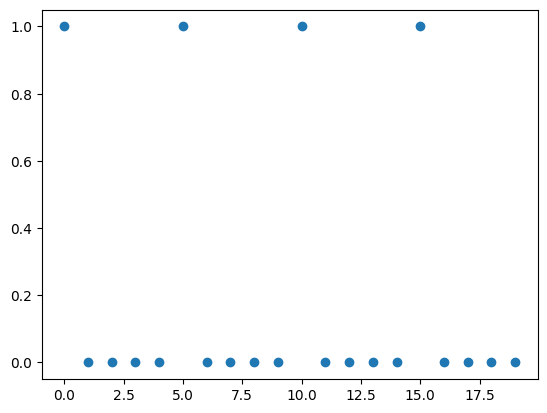

In [17]:
def spike_every_k_dataset(n: int, k: int, amplitude: float) -> Float[torch.Tensor, "n"]:

    output: Float[torch.Tensor, "n"] = torch.zeros(n)
    output[::k] = amplitude

    return output


dataset = spike_every_k_dataset(20, 5, 1.0)
plt.plot(dataset, "o")